# Setting up the environment

In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
from xgboost import XGBClassifier
import seaborn as sns

In [3]:
data_train = pd.read_csv('Dataset/train.csv')
data_test = pd.read_csv('Dataset/test.csv')

In [4]:
data_train.shape

(891, 12)

In [5]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
data_test.shape

(418, 11)

In [8]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Preprocessing the data

In [10]:
#To fill in missing values in age, we will randomize a value between (mean - std) and (mean + std)
avg_age = data_train['Age'].mean()
std_age = data_train['Age'].std()
age_null = np.random.randint(avg_age - std_age, avg_age + std_age, size = (data_train['Age'].isnull().sum()))
data_train['Age'][np.isnan(data_train['Age'])] = age_null
data_train['Age'] = data_train['Age'].astype(float)

avg_age = data_test['Age'].mean()
std_age = data_test['Age'].std()
age_null = np.random.randint(avg_age - std_age, avg_age + std_age, size = (data_test['Age'].isnull().sum()))
data_test['Age'][np.isnan(data_test['Age'])] = age_null
data_test['Age'] = data_test['Age'].astype(float)

In [11]:
#To fill in missing values in age, we will use the median
data_train['Fare'] = data_train['Fare'].fillna(data_train['Fare'].median())
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].median())

In [12]:
#To fill in missing values in Embarked, we will use the maximum counted category and then convert to integer
print(data_train['Embarked'].value_counts())
print(data_test['Embarked'].value_counts())
data_train['Embarked'] = data_train['Embarked'].fillna('S')
data_test['Embarked'] = data_test['Embarked'].fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64


In [13]:
data_train = pd.get_dummies(data_train, columns = ['Embarked'])
data_test = pd.get_dummies(data_test, columns = ['Embarked'])

In [14]:
#We'll take out the title from the name as it might be related to whether the person survived or not
data_train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [15]:
title = [name.split(",")[1].split(".")[0].strip() for name in data_train['Name']]
data_train['Title'] = pd.Series(title)
data_train['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [16]:
title = [name.split(",")[1].split(".")[0].strip() for name in data_test['Name']]
data_test['Title'] = pd.Series(title)
data_test['Title'].head()

0     Mr
1    Mrs
2     Mr
3     Mr
4    Mrs
Name: Title, dtype: object

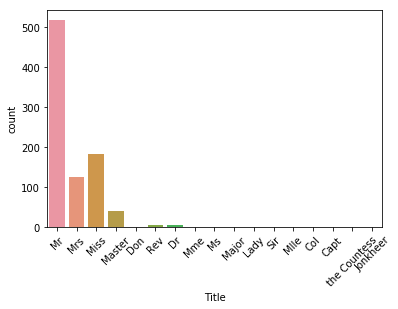

In [17]:
g = sns.countplot(x="Title", data = data_train)
g = plt.setp(g.get_xticklabels(), rotation = 45)

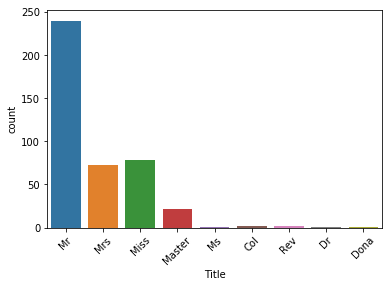

In [18]:
g = sns.countplot(x="Title", data = data_test)
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [19]:
data_train['Title'] = data_train['Title'].replace(['Don','Rev','Dr','Mme','Ms','Major','Lady','Sir','Mlle','Col','Capt','the Countess','Jonkheer','Dona'],'Rare')
data_test['Title'] = data_test['Title'].replace(['Don','Rev','Dr','Mme','Ms','Major','Lady','Sir','Mlle','Col','Capt','the Countess','Jonkheer','Dona'],'Rare')

In [20]:
data_train = pd.get_dummies(data_train, columns = ['Title'])
data_test = pd.get_dummies(data_test, columns = ['Title'])

In [21]:
data_train.drop(['Name'], axis = 1, inplace = True)
data_test.drop(['Name'], axis = 1, inplace = True)

In [22]:
#We will map the sex column to 0 and 1 for female and male respectively
data_train['Sex'] = data_train['Sex'].map({'female' : 0, 'male': 1}).astype(int)
data_test['Sex'] = data_test['Sex'].map({'female' : 0, 'male': 1}).astype(int)

In [23]:
#We will drop the ticket column as I can't figure out any kind of pattern in the data
data_train.drop(['Ticket'], axis = 1, inplace = True)
data_test.drop(['Ticket'], axis = 1, inplace = True)

In [24]:
# We will extract the prefix from each cabin number. The people that don't have cabins will have empty columns, so we will 
# replace that with X
data_train['Cabin'] = pd.Series([cabin[0] if not pd.isnull(cabin) else 'X' for cabin in data_train['Cabin']])
data_test['Cabin'] = pd.Series([cabin[0] if not pd.isnull(cabin) else 'X' for cabin in data_test['Cabin']])

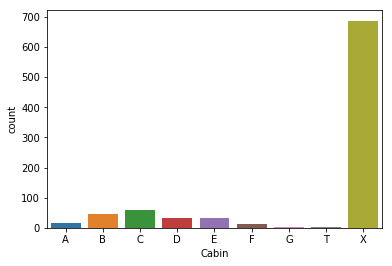

In [25]:
g = sns.countplot(data_train["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

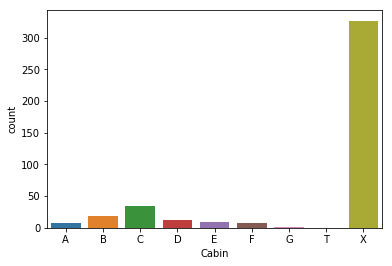

In [26]:
g = sns.countplot(data_test["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

In [27]:
data_train = pd.get_dummies(data_train, columns = ['Cabin'])
data_test = pd.get_dummies(data_test, columns = ['Cabin'])

In [28]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,...,Title_Rare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0,3,1,22.0,1,0,7.2500,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,0,38.0,1,0,71.2833,1,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,0,35.0,1,0,53.1000,0,0,...,0,0,0,1,0,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
#We will also create a new column called family size
data_train["Fsize"] = data_train["SibSp"] + data_train["Parch"] + 1
data_test["Fsize"] = data_test["SibSp"] + data_test["Parch"] + 1

In [30]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Sex             891 non-null int32
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Embarked_C      891 non-null uint8
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Title_Master    891 non-null uint8
Title_Miss      891 non-null uint8
Title_Mr        891 non-null uint8
Title_Mrs       891 non-null uint8
Title_Rare      891 non-null uint8
Cabin_A         891 non-null uint8
Cabin_B         891 non-null uint8
Cabin_C         891 non-null uint8
Cabin_D         891 non-null uint8
Cabin_E         891 non-null uint8
Cabin_F         891 non-null uint8
Cabin_G         891 non-null uint8
Cabin_T         891 non-null uint8
Cabin_X         891 non-null uint8
Fsize           

In [31]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 24 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Sex             418 non-null int32
Age             418 non-null float64
SibSp           418 non-null int64
Parch           418 non-null int64
Fare            418 non-null float64
Embarked_C      418 non-null uint8
Embarked_Q      418 non-null uint8
Embarked_S      418 non-null uint8
Title_Master    418 non-null uint8
Title_Miss      418 non-null uint8
Title_Mr        418 non-null uint8
Title_Mrs       418 non-null uint8
Title_Rare      418 non-null uint8
Cabin_A         418 non-null uint8
Cabin_B         418 non-null uint8
Cabin_C         418 non-null uint8
Cabin_D         418 non-null uint8
Cabin_E         418 non-null uint8
Cabin_F         418 non-null uint8
Cabin_G         418 non-null uint8
Cabin_X         418 non-null uint8
Fsize           418 non-null int64
dtypes: float64(2), int32(1), int64(5), uint8(16)
m

In [32]:
X_train = data_train.drop(['Survived'], axis = 1)
y_train = data_train['Survived']

In [33]:
skf = KFold(n_splits = 5, shuffle = True, random_state = 11)
kf = KFold(n_splits = 5, random_state = 17)

In [34]:
def base_pred(mod, X_train, y_train, data_test):
    base_train_pred = np.zeros(X_train.shape[0])
    base_test_pred = np.zeros(data_test.shape[0])
    base_test_pred_skf = np.zeros((5, data_test.shape[0]))
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        X_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        X_te = X_train.iloc[test_index]

        mod.fit(X_tr, y_tr)

        base_train_pred[test_index] = mod.predict_proba(X_te)[:,1]
        base_test_pred_skf[i, :] = mod.predict_proba(data_test)[:,1]
    base_test_pred[:] = base_test_pred_skf.mean(axis = 0)
    return base_train_pred.reshape(-1,1), base_test_pred.reshape(-1,1)

# Creating the stacking ensemble and using CV to find best params

In [35]:
lr_params = {
    'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)
}

rf_params = {
    'n_estimators': (100, 250, 500),
    'max_depth': (4, 8, 10),
    'min_samples_leaf': (2, 4, 8)
}

ada_params = {
    'n_estimators': (100, 250, 500),
    'learning_rate': (0.3, 0.5, 0.7)
}

gb_params = {
    'n_estimators': (100, 250, 500),
    'max_depth': (4, 8, 10),
    'min_samples_leaf': (4, 8, 10) 
}

et_params = {
    'n_estimators': (100, 250, 500),
    'max_depth': (4, 8, 10),
    'min_samples_leaf': (4, 8, 10) 
}

svc_params = {
    'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)
}

In [36]:
lr = LogisticRegression()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
et = ExtraTreesClassifier()
svc = SVC(kernel = 'linear', probability = True)

In [37]:
gcv_lr = GridSearchCV(lr, lr_params, n_jobs = -1, cv = skf, verbose = 1)
gcv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [38]:
gcv_rf = GridSearchCV(rf, rf_params, n_jobs = -1, cv = skf, verbose = 1)
gcv_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   18.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': (100, 250, 500), 'max_depth': (4, 8, 10), 'min_samples_leaf': (2, 4, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [39]:
gcv_ada = GridSearchCV(ada, ada_params, n_jobs = -1, cv = skf, verbose = 1)
gcv_ada.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': (100, 250, 500), 'learning_rate': (0.3, 0.5, 0.7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [40]:
gcv_gb = GridSearchCV(gb, gb_params, n_jobs = -1, cv = skf, verbose = 1)
gcv_gb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   30.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': (100, 250, 500), 'max_depth': (4, 8, 10), 'min_samples_leaf': (4, 8, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [41]:
gcv_et = GridSearchCV(et, et_params, n_jobs = -1, cv = skf, verbose = 1)
gcv_et.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   16.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': (100, 250, 500), 'max_depth': (4, 8, 10), 'min_samples_leaf': (4, 8, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [42]:
gcv_svc = GridSearchCV(svc, svc_params, n_jobs = -1, cv = skf, verbose = 1)
gcv_svc.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 24.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [43]:
lr = gcv_lr.best_estimator_
rf = gcv_rf.best_estimator_
ada = gcv_ada.best_estimator_
gb = gcv_gb.best_estimator_
et = gcv_et.best_estimator_
svc = gcv_svc.best_estimator_

# Training and finding the feature importances

In [44]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
ada.fit(X_train, y_train)
gb.fit(X_train, y_train)
et.fit(X_train, y_train)
svc.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [45]:
rf_feature = rf.feature_importances_
ada_feature = ada.feature_importances_
gb_feature = gb.feature_importances_
et_feature = et.feature_importances_
lr_feature = abs(lr.coef_.flatten())/abs(lr.coef_.flatten()).sum()
svc_feature = abs(svc.coef_.flatten())/abs(svc.coef_.flatten()).sum()

In [46]:
cols = X_train.columns.values
feature_dataframe = pd.DataFrame( {'features': cols,
     'Logistic Regression feature importances': lr_feature ,                             
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature,
    'SVC feature importances': svc_feature                             
    })

In [47]:
#Code for this was found online

trace = go.Scatter(
    y = feature_dataframe['Logistic Regression feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Logistic Regression feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Logistic Regression feature importances',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

######################################################

trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

#####################################################

trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees  feature importances',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

############################################################

trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost feature importances',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

##############################################################

trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boost feature importances',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

################################################################

trace = go.Scatter(
    y = feature_dataframe['SVC feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['SVC feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'SVC feature importances',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [48]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)

In [49]:
trace = go.Scatter(
    y = feature_dataframe['mean'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['mean'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Mean feature importances',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


# Training and finding predictions of base classifiers on train and test data

In [67]:
X_train.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X',
       'Fsize'],
      dtype='object')

In [62]:
cols = data_test.columns.tolist()

In [54]:
data_test['Cabin_T'] = 0

In [64]:
cols = cols[:22] + cols[-1:] + cols[22:-1]

In [68]:
data_test = data_test[cols]

In [69]:
data_test.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X',
       'Fsize'],
      dtype='object')

In [70]:
lr_train_pred, lr_test_pred = base_pred(lr, X_train, y_train, data_test)
rf_train_pred, rf_test_pred = base_pred(rf, X_train, y_train, data_test)
ada_train_pred, ada_test_pred = base_pred(ada, X_train, y_train, data_test)
gb_train_pred, gb_test_pred = base_pred(gb, X_train, y_train, data_test) 
et_train_pred, et_test_pred = base_pred(et, X_train, y_train, data_test) 
svc_train_pred, svc_test_pred = base_pred(svc, X_train, y_train, data_test) 

In [71]:
X_train_new = np.concatenate((lr_train_pred, rf_train_pred, ada_train_pred, gb_train_pred, et_train_pred, svc_train_pred), axis = 1)
data_test_new = np.concatenate((lr_test_pred, rf_test_pred, ada_test_pred, gb_test_pred, et_test_pred, svc_test_pred), axis = 1)

In [72]:
X_train_new = pd.DataFrame(X_train_new)
data_test_new = pd.DataFrame(data_test_new)

# Second level XGBoost Classifier using first level output

In [73]:
xgb = XGBClassifier(n_estimators = 2000, gamma = 0.9, subsample = 0.8, colsample_bytree = 0.8, objective = 'binary:logistic', nthread = -1, scale_pos_weight = 1)
xgb_params = {'learning_rate': (0.02, 0.05, 0.1),
              'max_depth': (2, 4, 8),
              'min_child_weight': (1,2,4,8)}

In [74]:
gcv_xgb = GridSearchCV(xgb, xgb_params, n_jobs = -1, cv = skf, verbose = True)
gcv_xgb.fit(X_train_new, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.9,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': (0.02, 0.05, 0.1), 'max_depth': (2, 4, 8), 'min_child_weight': (1, 2, 4, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [75]:
xgb = gcv_xgb.best_estimator_

In [76]:
xgb.fit(X_train_new, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.9,
       learning_rate=0.02, max_delta_step=0, max_depth=2,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [77]:
pred = xgb.predict(data_test_new)

In [78]:
submission = pd.DataFrame({ 'PassengerId': data_test['PassengerId'],
                            'Survived': pred })
submission.to_csv("submissionewfe.csv", index=False)